In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

# initialize output
wing_characters = dict()
wing_characters_stats = dict()

In [2]:
orig_img_dir = './real_samples/nearest1000/orig'
d40_img_dir = './real_samples/nearest1000/d40'
d512_img_dir = './real_samples/nearest1000/d512'
# orig_img_dir = '../DFC_VSC/wing_characters/real_samples/rand1000/orig'
# d40_img_dir = '../DFC_VSC/wing_characters/real_samples/rand1000/d40'
orig_img_files = [f'./{orig_img_dir}/{f}' for f in os.listdir(f'{orig_img_dir}') if f.endswith('.jpg')]
d40_img_files = [f'./{d40_img_dir}/{f}' for f in os.listdir(f'{d40_img_dir}') if f.endswith('.png')]
d512_img_files = [f'./{d512_img_dir}/{f}' for f in os.listdir(f'{d512_img_dir}') if f.endswith('.png')]
orig_img_files.sort()
d40_img_files.sort()
d512_img_files.sort()
len(orig_img_files), len(d40_img_files), len(d512_img_files)

(1071, 1071, 1071)

In [3]:
# 取出亮度值的指定百分位數
def hsv_vp(per, hsvs):
    return np.quantile(np.concatenate(hsvs)[:,2], per/100)

def minMaxScaler(v):
    return (v - v.min()) / (v.max() - v.min())

def leftSideSample(img):
    return img[78:178, :100, :]

In [4]:
feat_on_x_edge_indices = dict(orig=[], d40=[], d512=[])

In [15]:
# target = 'orig'
# target = 'd40'
target = 'd512'

if target == 'orig':
    target_img_files = orig_img_files
elif target == 'd40':
    target_img_files = d40_img_files
elif target == 'd512':
    target_img_files = d512_img_files
else:
    target_img_files = orig_img_files + d512_img_files

# 前景的 RGB 值
rgbs = []
# 前景的 HSV 值
hsvs = []

grays = []

# 前景所在的 y, x 坐標值
img_fg_idxs = []

bboxes = []
w_binarys = []

for idx_, w_ in enumerate(target_img_files):
    w_img = cv2.imread(f'{w_}', cv2.IMREAD_UNCHANGED)[:,:,:3]
    if target == 'orig':
        w_img = cv2.blur(w_img, (7, 7))
    w_img = leftSideSample(w_img)
    w_img = cv2.cvtColor(w_img, cv2.COLOR_BGR2RGB)
    
    w_img_gray = cv2.cvtColor(w_img, cv2.COLOR_RGB2GRAY)
    w_img_hsv = cv2.cvtColor(w_img, cv2.COLOR_RGB2HSV)
        
    w_rgb = w_img.reshape(-1, 3)
    w_gray = w_img_gray.reshape(-1)
    w_hsv = w_img_hsv.reshape(-1, 3)
    
    rgbs.append(w_rgb)
    hsvs.append(w_hsv)
    grays.append(w_gray)
    

# 翅膀平均色調(無意義)、平均飽和度、平均亮度
hsv_mean = np.array([w_.mean(axis=0) for w_ in hsvs])

# brightness
gray_mean = np.array([w_.mean(axis=0) for w_ in grays])

# RGB 各自的平均值
rgb_means = np.array([np.mean(w_, axis=0) for w_ in rgbs])

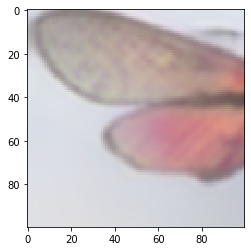

In [16]:
plt.imshow(w_img)

In [17]:
def qmean(group_dt, var, q):
    qv = np.quantile(group_dt[var], q)
    vals_ = group_dt[group_dt[var] >= qv][var]
    return vals_.mean()


In [18]:
from sklearn.metrics import pairwise_distances
# for wing_i in range(10):
for wing_i in range(len(rgbs)):
    
    print(wing_i, end='\r')
    
    # 計算前景(翅膀) RGB 值中，任兩點的 歐式距離
    pwd_rgb = pairwise_distances(rgbs[wing_i])
    
    # 轉回影像的 xy 平面
    #     xy_pwds = []
    #     for i_ in range(len(img_fg_idxs[wing_i][0])):
    #         for j_ in range(len(img_fg_idxs[wing_i][0])):
    #             xy_pwds.append((img_fg_idxs[wing_i][1][i_], img_fg_idxs[wing_i][0][i_], pwd_rgb[i_][j_]))

    #     xy_pwds_df = pd.DataFrame(xy_pwds, columns=['x','y','pwd'])

    pwd_rgb_pixel_mean = np.mean(pwd_rgb, axis=1)
#     xy_pwds_mean_df = pd.DataFrame(np.array(np.meshgrid(np.arange(10000, dtype=int), np.arange(10000, dtype=int))).T.reshape(-1, 2), columns=['x', 'y'])
#     xy_pwds_mean_df['pwd'] = pwd_rgb.reshape(-1)
    
    
    # 算出每個點到任意其他點的 RGB 歐式距離平均，這個值愈大代表該部位顏色愈獨特
#     xy_pwds_mean_df = xy_pwds_df.groupby(['x', 'y']).mean().reset_index()
#     xy_pwds_mean_df['pwd_valid'] = xy_pwds_mean_df['pwd'].values
    pwd_rgb_pixel_mean_valid = pwd_rgb_pixel_mean.copy()
    
    # 抑制 q .95 以上的值，減緩修圖時造成的邊緣雜訊
#     xy_pwds_mean_df.loc[xy_pwds_mean_df.pwd > xy_pwds_mean_df.pwd.quantile(.95), 'pwd_valid'] = xy_pwds_mean_df.pwd.quantile(.95)
    pwd_rgb_pixel_mean = np.where(pwd_rgb_pixel_mean > np.quantile(pwd_rgb_pixel_mean, .95), np.quantile(pwd_rgb_pixel_mean, .95), pwd_rgb_pixel_mean)
    
    # 對獨特性做 min max scaling 標準化
#     xy_pwds_mean_df['pwd_norm'] = (xy_pwds_mean_df['pwd_valid'] - xy_pwds_mean_df['pwd_valid'].min()) / (xy_pwds_mean_df['pwd_valid'].max() - xy_pwds_mean_df['pwd_valid'].min())
    pwd_rgb_pixel_mean_norm = (pwd_rgb_pixel_mean_valid - pwd_rgb_pixel_mean_valid.min()) / (pwd_rgb_pixel_mean_valid.max() - pwd_rgb_pixel_mean_valid.min())
    # 改成用理論 max 值標準化，不然那些平平無奇的翅膀也算起來也可能變得很 diverse
    # xy_pwds_mean_df['pwd_norm'] = xy_pwds_mean_df['pwd_valid'] / np.sqrt(3 * 255**2)
    # xy_pwds_mean_df['pwd_norm'] = xy_pwds_mean_df['pwd_valid'] / xy_pwds_mean_df['pwd_valid'].min()

    # 水平翻轉翅膀，讓 x 坐標與翅基-翅尖方向一致，並且將 x 值做 min max scaling
#     xy_pwds_mean_df['x_norm'] = (xy_pwds_mean_df.x.max() - xy_pwds_mean_df.x) / (xy_pwds_mean_df.x.max() - xy_pwds_mean_df.x.min())
    pwd_rgb_pixel_mean_x_norm = (100 - np.repeat(np.arange(100, dtype=int), 100)) / 100
    # 將 y 值做 min max scaling
    # xy_pwds_mean_df['y_norm'] = (xy_pwds_mean_df.y - xy_pwds_mean_df.y.min()) / (xy_pwds_mean_df.y.max() - xy_pwds_mean_df.y.min())
    # 將色彩的獨特性與距離翅基的距離加權
    # xy_pwds_mean_df['pwd_x_weighted'] = xy_pwds_mean_df.x_norm * xy_pwds_mean_df.pwd_norm
    # xy_pwds_mean_df['pwd_y_weighted'] = xy_pwds_mean_df.y_norm * xy_pwds_mean_df.pwd_norm

    # 參考 x 對獨特性加權值做平均，用來看獨特色彩主要分部的 x 位置
    # feat_on_x_edge_indice = xy_pwds_mean_df.groupby('x').mean().pwd_x_weighted.values.mean()
    # 改成用 pwd groupby x 的前 P % 值做平均比較有代表性
    tmp_df = pd.DataFrame({'x_norm':pwd_rgb_pixel_mean_x_norm, 'pwd_norm': pwd_rgb_pixel_mean_norm})
    pixel_column_means = tmp_df.groupby('x_norm').apply(qmean, 'pwd_norm', .5)
    # pixel_column_means = xy_pwds_mean_df.groupby('x_norm').mean()
    
    # distinctiveness_prN = pixel_column_means[pixel_column_means >= 0.7]
    loc_prN = pixel_column_means.index.values[pixel_column_means.values >= np.quantile(pixel_column_means.values, .5)]
    # distinctiveness_x_weighted = pixel_column_means.index.values * pixel_column_means.pwd_norm.values
    feat_on_x_edge_indice = loc_prN.mean() / loc_prN.var() #distinctiveness_x_weighted.mean()# / distinctiveness_x_weighted.var()
    # feat_on_x_edge_indice = pixel_column_means.mean()
    feat_on_x_edge_indices[target].append(feat_on_x_edge_indice)

In [30]:
# pd.DataFrame(feat_on_x_edge_indices).to_csv('./rec_correlation_test/nearest2centroids1000_PDDI.csv')

In [35]:
feat_on_x_edge_indices_df = pd.read_csv('./rec_correlation_test/nearest2centroids1000_PDDI.csv', index_col=0)

In [36]:
feat_on_x_edge_indices_df

,orig,d40,d512
0,25.851035,18.406536,24.037674
1,28.703041,29.231948,28.110515
2,11.578558,32.427990,17.557062
3,5.213065,6.069390,5.514785
4,29.342354,31.405929,24.558272
...,...,...,...
1066,36.254502,36.254502,36.254502
1067,12.552192,12.141902,9.308191
1068,14.842664,25.509213,15.788454
1069,20.464474,15.496898,13.891295


0.8640227755153305 6.986e-321


Text(0.5, 1.0, 'd512')

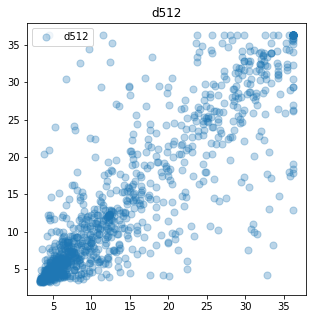

In [38]:
import scipy

r_target = 'd512'
# r_target = 'd40'

plt.rcParams['figure.figsize'] = [5, 5]
var1 = feat_on_x_edge_indices_df['orig']
var2 = feat_on_x_edge_indices_df[r_target]

plt.figure()

plt.scatter(var1, var2, s=50, alpha=.3, label=r_target)
pearsons_r, p = scipy.stats.pearsonr(var1, var2)

print(pearsons_r, p)

plt.legend()
plt.title(r_target)